# ML Final Report
### Ben Richardson and Kendra Noneman

#### Link for documentation: https://huggingface.co/docs/transformers/model_doc/clip

In [1]:
from PIL import Image
import requests
import torch
import numpy as np
from gtts import gTTS
import matplotlib.pyplot as plt
from playsound import playsound
from audio2numpy import open_audio
import ffmpeg
import numpy as np
import librosa
from scipy.signal import butter,filtfilt,find_peaks
from bregman.suite import Chromagram


from transformers import CLIPProcessor, CLIPModel

### Acoustic Model:

##### Hubert: 
"Forces the model to learn a combined acoustic and language model over the continuous inputs":
https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/hubert#overview



### Multimodal Model:

##### CLIPModel:
Model configuration class with all the parameters of the model. Initializing with a config file does not load the weights associated with the model, only the configuration.
 
##### from_pretrained:
Changes the weights (including mapping hidden states to vocabulary, pruning and initializing weights, tying the weights between the input embeddings and the output embeddings, etc...)
https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

Options for CLIP pre-trained openai models (4 of them):
https://huggingface.co/openai

##### CLIPProcessor:
Constructs a CLIP processor which wraps a CLIP feature extractor and a CLIP tokenizer into a single processor

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

In [4]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
print(inputs["input_ids"])
print(inputs["input_ids"].shape)


tensor([[49406,   320,  1125,   539,   320,  2368, 49407],
        [49406,   320,  1125,   539,   320,  1929, 49407]])
torch.Size([2, 7])


HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-US_DAVID_11.0
5
[ 2978  5840  8419 13280 15427]
[0.02232179 0.04597894 0.0310799  0.0287276  0.02870581]
[0.         1.         0.3702099  0.27077699 0.26985596]
5
[ 2978  5840  8419 12904 15375]
[0.02232179 0.04597783 0.03107873 0.02318005 0.02502829]
[0.         1.         0.37017765 0.03628079 0.11441076]


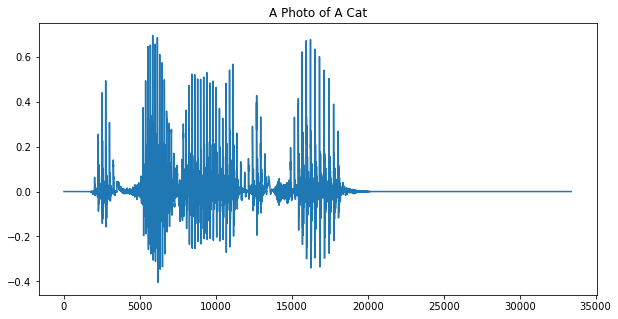

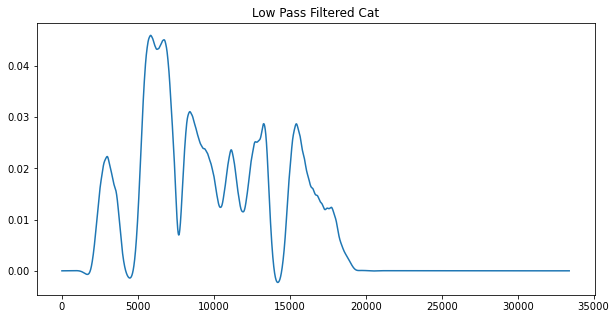

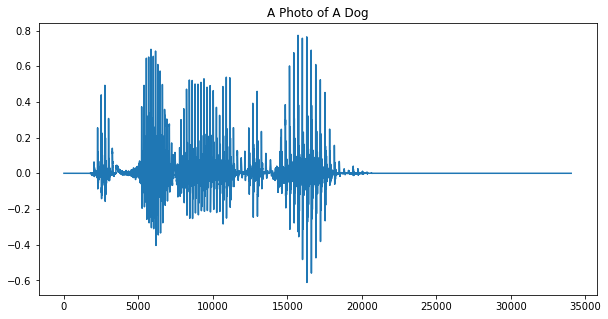

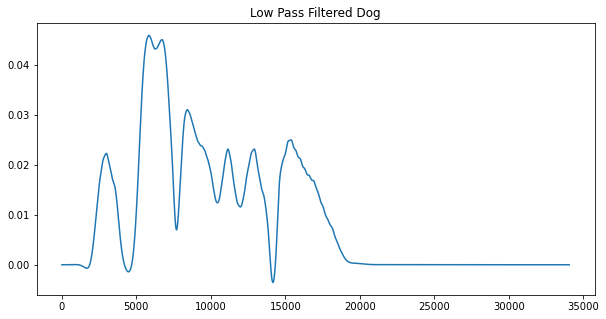

In [9]:
## Text to Speech, determine pitch contour
text_to_convert = "a photo of a cat"
language = "en"
import pyttsx3  
s = pyttsx3.init()   
s.say(text_to_convert)  
s.save_to_file(text_to_convert, 'speech.mp3')
s.runAndWait()
voice = s.getProperty('voice')   #getting to know current volume level (min=0 and max=1)
print(voice)
signal, fs = open_audio('speech.mp3')
F = Chromogram('speech.mp3', nfft=16384, wfft=8192, nhop=2205)
chroma_features = F.X
# SIGNAL
plt.figure(figsize = (10,5))
plt.plot(signal)
plt.title('A Photo of A Cat')
# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(signal, 20, fs, 2)
plt.figure(figsize = (10,5))
plt.plot(signal_lpf)
plt.title('Low Pass Filtered Cat')
# Find num_words peak
num_words = inputs["input_ids"].shape[1] - 2
print(num_words)
peaks, properties = find_peaks(signal_lpf,height=0.01,prominence=0.015)
print(peaks)
print(properties['peak_heights'])
heights_cat = properties['peak_heights']
heights_cat = heights_cat[0:num_words]
normalized_heights_cat = (heights_cat - np.min(heights_cat))/(np.max(heights_cat) - np.min(heights_cat))
print(normalized_heights_cat)


## SAME THING FOR DOG
text_to_convert = "a photo of a dog"
language = "en"
s = pyttsx3.init()   
s.say(text_to_convert)  
s.save_to_file(text_to_convert, 'speech.mp3')
s.runAndWait()

signal, fs = open_audio('speech.mp3')
# SIGNAL
plt.figure(figsize = (10,5))
plt.plot(signal)
plt.title('A Photo of A Dog')

# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(signal, 20, fs, 2)
plt.figure(figsize = (10,5))
plt.plot(signal_lpf)
plt.title('Low Pass Filtered Dog')
# Find num_words peak
num_words = inputs["input_ids"].shape[1] - 2
print(num_words)
peaks, properties = find_peaks(signal_lpf,height=0.01,prominence=0.011)
print(peaks)
print(properties['peak_heights'])
heights_dog = properties['peak_heights']
heights_dog = heights_dog[0:num_words]
normalized_heights_dog = (heights_dog - np.min(heights_dog))/(np.max(heights_dog) - np.min(heights_dog))
print(normalized_heights_dog)

In [6]:
# Find the n words with largest auditory cue, and then set the attention mask to 1 only for those words
attention_mask_cat = np.concatenate([np.ones(1),normalized_heights_cat,np.ones(1)])
attention_mask_dog = np.concatenate([np.ones(1),normalized_heights_dog,np.ones(1)])
print(attention_mask_cat)
print(attention_mask_dog)
inputs["attention_mask"] = torch.Tensor([attention_mask_cat,attention_mask_dog])
#torch.Tensor([np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist(),np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist()])
#print(np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist())


[1.         0.         1.         0.3702099  0.27077699 0.26985596
 1.        ]
[1.         0.         1.         0.37017765 0.03628079 0.11441076
 1.        ]


<ipython-input-6-f9507baaec06>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  inputs["attention_mask"] = torch.Tensor([attention_mask_cat,attention_mask_dog])


In [7]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [8]:
print(probs)

tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward0>)
